# Horizon Extension model

In this notebook, we will go through the task of horizon extension for a single predicted horizon. The objective is to enlarge a horizon covered area.
As you can see, seismic horizon detection models such as [Carcass Interpolation](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb) and 
[Inter-cube generalization](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb) sometimes predict horizons with holes. 
This notebook describes a model that is trained to cover these holes.

* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Data preprocessing](#Data-preprocessing)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Validation](#Validation)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

# Task-description

Given a cube and a horizon with insufficient coverage we are going to train a model to extend this particular horizon.

# Dataset

In [2]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
# some imports
import sys
import warnings

import numpy as np
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

sys.path.append('../../')
from seismiqb import *
from seismiqb.src.controllers.torch_models import ExtensionModel

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow import D, B, V, P, R, L

warnings.filterwarnings("ignore")
from seismiqb.batchflow.models.torch.layers import ConvBlock
from seismiqb.batchflow.batchflow.models.torch import EncoderDecoder
from seismiqb.batchflow.batchflow.models.utils import unpack_args

Load cube and a horizon with holes:

In [94]:
cube_path = "/notebooks/data/seismic/CUBE_2/M_cube.hdf5"
horizon_dir = '/PREDICTED_HORIZONS/PREDICTIONS_WITH_HOLES/*'

ds = SeismicCubeset(FilesIndex(path=cube_path, no_ext=True))

ds.load(horizon_dir)
# ds.create_sampler(dst='train_sampler') # create sampler to sample crops containing horizon
ds.modify_sampler(dst='train_sampler', finish=True)

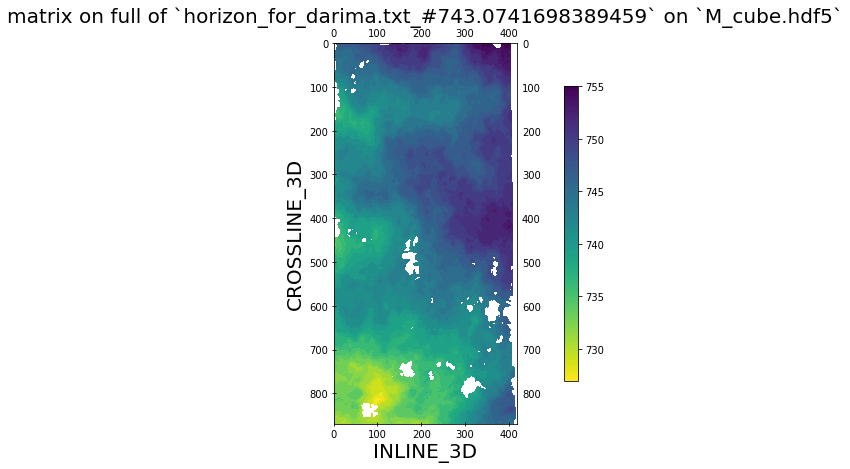

In [95]:
ds.labels[ds.indices[0]][0].show()

# Data preprocessing

In [6]:
# Define come constants
BATCH_SIZE = 64
CROP_SHAPE = [1, 64, 64]

Let's define load pipeline to load seismic data and create binary masks from the horizon data. Note that we want to use in training only parts of the horizon without holes.
To do so we add `mask_rebatch` action with `threshold=0.99` that will remove from the batch all crops that have less than 99 % horizon coverage so actual batch_size fed to the model will be less than `BATCH_SIZE`

In [97]:
load = (Pipeline()
        .crop(points=D('train_sampler')(BATCH_SIZE),
              shape=CROP_SHAPE, side_view=True)
        .create_masks(dst='masks', width=3)
        .mask_rebatch(src='masks', threshold=0.9)
        .load_cubes(dst='images')
        .adaptive_reshape(src=['images', 'masks'],
                          shape=CROP_SHAPE)
        .scale(mode='q', src='images')
       )

To train a model to extend a specific horizon we have to provide data about it to the model.
To do so we thin out the loaded mask and leave 10-40 percent of it nonzero (depending on size and number of holes in the horizon).

Here we define mask distortion pipeline that thins out a crop mask and saves it into `prior_mask`-component of the batch.

In [101]:
def functor(scale):
    return lambda m: np.sin(m[:, 0] * scale)

distort = (Pipeline()
            .transpose(src='masks', order=(1, 2, 0))
            .filter_out(src='masks', dst='prior_masks',
                        expr=lambda m: m[:, 0],
                        low=P(R('uniform', low=0., high=0.4)),
                        length=P(R('uniform', low=0.30, high=0.5)))
#             .filter_out(src='prior_masks', dst='prior_masks',
#                         expr=L(functor)(R('uniform', low=15, high=35)), low=0.0, p=0.7)
            .transpose(src=['masks', 'prior_masks'], order=(2, 0, 1))
          )

Let's combine pipelines and feed dataset to take a look at the data:

In [102]:
show_pipeline = (load + distort) << ds
batch = show_pipeline.next_batch(1)

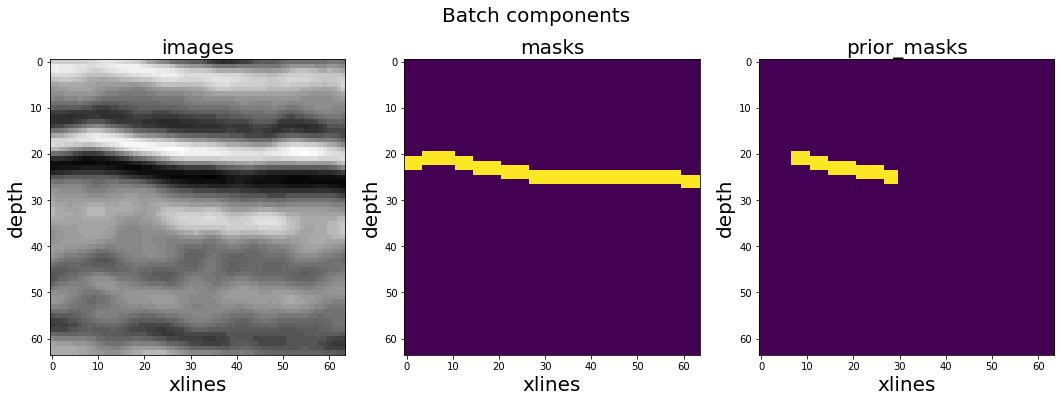

In [103]:
batch.plot_components('images', 'masks', 'prior_masks', idx=0, mode='separate')

We also define a standard augmentation pipeline:

In [104]:
augment = (Pipeline()
            .transpose(src=['images', 'masks', 'prior_masks'], order=(1, 2, 0))
            .rotate(angle=P(R('uniform', -30, 30)),
                    src=['images', 'masks', 'prior_masks'], p=0.3)
            .flip(src=['images', 'masks', 'prior_masks'], axis=1, p=0.3)
            .transpose(src=['images', 'masks', 'prior_masks'], order=(2, 0, 1))
          )

# Model architecture

In previous cells we have created `prior_masks` component that is a thin-out copy of an actual `mask` component. Our idea is to provide a partial horizon to the model along with a seismic data and train model to restore it. 



We modify the traditional [EncoderDecoder](https://github.com/analysiscenter/batchflow/blob/master/batchflow/models/torch/encoder_decoder.py) architecture and add an additional Encoder branch that is fed with prior information about the horizon of interest. Before downsampling steps results of both branches are combined and sent to the next block of the first Encoder branch.
For the sake of brevity, we don't provide model code in this notebook, but you can find it in [Extension model definition]().

<p align="center">
    <img src="images/architecture.png" alt="Drawing" />
</p>

Both encoder branches have a similar layout. We use 4 downsampling steps with ResNet blocks and increase the number of filters from 32 twice at each step.
We train our model with the Dice loss.

In [106]:
class Dice(nn.Module):
    """ Dice coefficient as a loss function. """
    def forward(self, prediction, target):
        prediction = torch.sigmoid(prediction)
        dice_coeff = 2. * (prediction * target).sum() / (prediction.sum() + target.sum() + 1e-7)
        return 1 - dice_coeff

    
MODEL_CONFIG = {
    # Model layout
    'body/encoder': {
        'num_stages': 3,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [32, 64, 128],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 128,
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 3,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32],
            'attention': 'scse',
        },
    },

    'output': 'sigmoid',
    # Train configuration
    'loss': Dice(),
    'optimizer': {'name': 'Adam', 'lr': 0.001,},
    'decay': {'name': 'exp', 'gamma': 0.1},
    'n_iters': 150,
    }

# Training

Define pipeline that initializes a model with the model_config defined above and feeds seismic data, prior masks and true masks to the model:

In [107]:
train_model = (Pipeline()
                .init_variable('loss_history', default=[])
                .init_model('dynamic', ExtensionModel, 'base', MODEL_CONFIG)
                .train_model('base', fetches='loss', save_to=V('loss_history', mode='a'),
                             images=B('images'),
                             prior_masks=B('prior_masks'),
                             masks=B('masks'))
                )

Combine all pipelines to one and feed actual dataset to it:

In [108]:
training_pipeline = (load + distort + augment + train_model) << ds

Run training for N_ITERS iterations:

In [109]:
N_ITERS = 300
training_pipeline.run(D('size'), n_iters=N_ITERS, bar='n')

Loss function plot

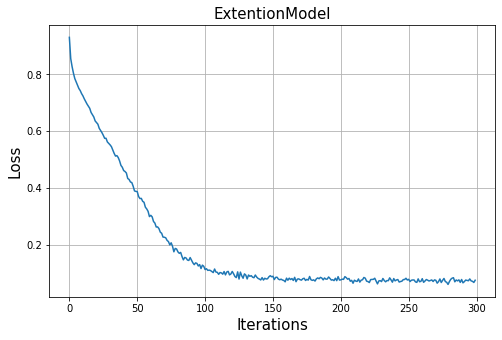

In [110]:
plot_loss(training_pipeline.v('loss_history'), ylabel='Loss', title='ExtentionModel')

# Inference

To cover the holes in the initial horizon we have to generate crops coordinates next to them so that each crop contains a partial horizon that is used as input to the trained model. Crop generator is created using Cubeset method `make_extension_grid` that generates crops using horizon boundaries coordinates. After extracting predicted horizons and merging them to the initial one we repeat this procedure with extended horizon boundaries.


First, we define an inference pipeline. Note that on an inference step we don't use mask distortion `filter_out` and augmentation actions.
Along with data loading and model prediction, we add `masks_to_horizons` action that extracts horizons from predicted masks.

In [111]:
inference_pipeline = (
    Pipeline()
    # Init everything
    .init_variable('predicted_horizons', default=list())
    .import_model('base', training_pipeline)
    # Load data
    .crop(points=L(D('grid_gen')), shape=L(D('shapes_gen')))
    .load_cubes(dst='images')
    .create_masks(dst='prior_masks', width=3)
    .adaptive_reshape(src=['images', 'prior_masks'],
                      shape=CROP_SHAPE)
    .scale(mode='q', src='images')
    # Use model for prediction
    .predict_model('base',
                   B('images'),
                   B('prior_masks'),
                   fetches='predictions',
                   save_to=B('predicted_masks', mode='w'))
    .transpose(src='predicted_masks', order=(1, 2, 0))
    .masks_to_horizons(src='predicted_masks', threshold=0.5, minsize=16,
                       order=L(D('orders_gen')), dst='horizons', skip_merge=True)
    .update(V('predicted_horizons', mode='e'), B('horizons')))

We can run inference iterations either on some stop condition on extended horizon length (e.g. equals zero) or fixed iteration number. In this situation, because the sizes of holes in the given horizon are small we set a small number of iterations.

In [112]:
N_STEPS = 6

In [113]:
prev_len = 0
pred_horizon = ds.labels[ds.indices[0]][0].copy()

for _ in tqdm(range(N_STEPS)):
    ds.make_extension_grid(ds.indices[0],
                           crop_shape=CROP_SHAPE,
                           stride=10,
                           labels_src=pred_horizon,
                           batch_size=128)

    # Add current horizon to dataset labels in order to make create_masks work
    ds.labels[ds.indices[0]] = [pred_horizon]

    inference_pipeline = (inference_pipeline << ds)
    try:
        for _ in range(ds.grid_iters):
            inference_pipeline.next_batch(1, n_epochs=None)
    except TypeError:
        # no additional predicts
        break

    horizons = [*inference_pipeline.v('predicted_horizons')]
    for hor in horizons:
        merge_code, _ = Horizon.verify_merge(pred_horizon, hor,
                                             mean_threshold=5.5,
                                             adjacency=5)
        if merge_code == 3:
            _ = pred_horizon.overlap_merge(hor, inplace=True)

    curr_len = len(pred_horizon)
    if (curr_len - prev_len) < 5:
        break
    print(f'Extended from {prev_len} to {curr_len}, + {curr_len - prev_len}')
    prev_len = curr_len

 17%|█▋        | 1/6 [00:03<00:17,  3.46s/it]

Extended from 0 to 351561, + 351561


 33%|███▎      | 2/6 [00:04<00:10,  2.63s/it]

Extended from 351561 to 352035, + 474


 67%|██████▋   | 4/6 [00:04<00:02,  1.41s/it]

Extended from 352035 to 352116, + 81
Extended from 352116 to 352123, + 7


 83%|████████▎ | 5/6 [00:04<00:00,  1.00it/s]

Extended from 352123 to 352133, + 10


# Validation

To evaluate final horizon we evaluate our metric:


Number of labeled points:                         352133
Number of points inside borders:                  352248
Perimeter (length of borders):                    2591
Percentage of labeled non-bad traces:             0.9983103175525687
Percentage of labeled traces inside borders:      0.9996735254706911
Number of holes inside borders:                   33



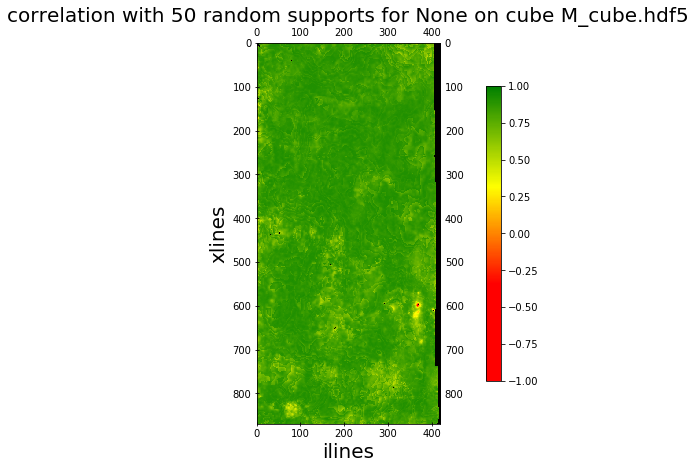

In [114]:
metrics = pred_horizon.evaluate()

# Criticism

The horizon quality in the extended areas sometimes can be not satisfying enough and extended horizon may need some post-processing steps such as running through an [Enhancement]() model.

# Proposals for the improvement and further development

The proposed architecture may be not optimal and an extensive research on different number of blocks, filters and combine operations between branches must be performed.